In [2]:
import gnn_tracking_hpo
from gnn_tracking_hpo.util.paths import find_checkpoints, get_config, add_scripts_path


In [6]:
add_scripts_path()

In [3]:
checkpoint = find_checkpoints("tcn-perfect-s9-tc", "474d348c")[-1]
config = get_config("tcn-perfect-s9-tc", "474d348c")

In [4]:
config.update({"n_graphs_train": 1, "n_graphs_val": 100, "n_graphs_test": 1})

In [7]:
from tune_02_perfect_ec_sectorized_truth_cut import DynamicTCNTrainable

trainable = DynamicTCNTrainable(config)

DEBUG: Got config
{'attr_pt_thld': 0.6120378482822557,
 'batch_size': 1,
 'gnn_tracking_experiments_hash': '52969e3f99d05b686693d886410194a9b41b99b8',
 'gnn_tracking_hash': '7c7efa8c6a890d175807df185637032bfaf0e83e',
 'lr': 0.000352944777010661,
 'lw_background': 2.3636993448316492e-06,
 'lw_potential_attractive': 1.0,
 'lw_potential_repulsive': 0.5218690347548827,
 'm_L_hc': 3,
 'm_alpha_hc': 0.7946792381015035,
 'm_e_dim': 5,
 'm_ec_tnr': 1.0,
 'm_ec_tpr': 1.0,
 'm_h_dim': 5,
 'm_h_outdim': 2,
 'm_hidden_dim': 116,
 'm_interaction_edge_hidden_dim': 124,
 'm_interaction_node_hidden_dim': 120,
 'n_graphs_test': 1,
 'n_graphs_train': 1,
 'n_graphs_val': 100,
 'optimizer': 'adam',
 'q_min': 0.4007277405721034,
 'repulsive_radius_threshold': 3.0908135564502364,
 'sb': 0.10112383165612691,
 'scheduler': None,
 'sector': 9,
 'test': False,
 'training_pt_thld': 0.9,
 'training_without_noise': True,
 'training_without_non_reconstructable': True}
INFO: Loading data to cpu memory
INFO: Loading 

In [8]:
trainable.load_checkpoint(checkpoint, device="cpu")

In [9]:
from gnn_tracking.training.tcn_trainer import TCNTrainer


## Using perfect EC with varying TPR

In [3]:
import numpy as np

all_results = []
tprs = np.linspace(1., 0.8, 5)

In [24]:
from gnn_tracking.models.edge_classifier import PerfectEdgeClassification

In [25]:
for tpr in tprs:
    trainable.trainer.model._gtcn.ec = PerfectEdgeClassification(tpr=tpr, tnr=1)
    result = TCNTrainer.test_step(trainable.trainer)
    all_results.append(result)

INFO: Starting hyperparameter scan for clustering
INFO: Completed 12 trials, pruned 0 trials
DEBUG: Evaluating all metrics for best clustering
INFO: Evaluating all metrics took 14.59 seconds
INFO: Clustering hyperparameter scan & metric evaluation took 46.29 seconds
DEBUG: Starting from params: {'eps': 0.96076051228748, 'min_samples': 1}
INFO: Starting hyperparameter scan for clustering
INFO: Completed 12 trials, pruned 0 trials
DEBUG: Evaluating all metrics for best clustering
INFO: Evaluating all metrics took 3.17 seconds
INFO: Clustering hyperparameter scan & metric evaluation took 30.42 seconds
DEBUG: Starting from params: {'eps': 0.9599247213554087, 'min_samples': 1}
INFO: Starting hyperparameter scan for clustering
INFO: Completed 5 trials, pruned 7 trials
DEBUG: Evaluating all metrics for best clustering
INFO: Evaluating all metrics took 16.15 seconds
INFO: Clustering hyperparameter scan & metric evaluation took 47.31 seconds
DEBUG: Starting from params: {'eps': 0.95992472135540

In [33]:
all_tc_dm = [c["tc_trk.double_majority"] for c in all_results]
all_pt09_dm = [c["trk.double_majority_pt0.9"] for c in all_results]
all_pt15_dm = [c["trk.double_majority_pt1.5"] for c in all_results]

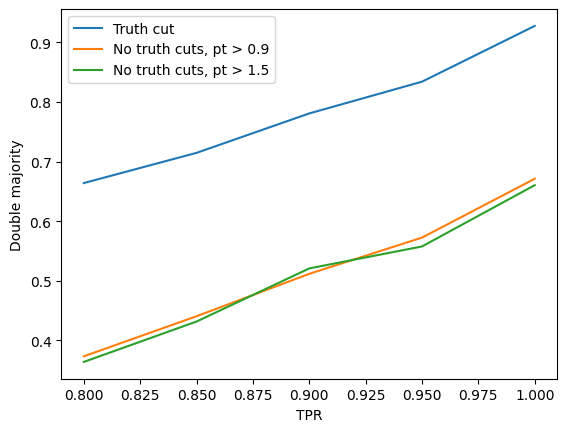

In [37]:
from matplotlib import pyplot as plt

plt.plot(tprs, all_tc_dm, label="Truth cut")
plt.plot(tprs, all_pt09_dm, label="No truth cuts, pt > 0.9")
plt.plot(tprs, all_pt15_dm, label="No truth cuts, pt > 1.5")
plt.xlabel("TPR")
plt.ylabel("Double majority")
plt.legend()

In [31]:
all_results[0]

{'acc_pt1.5': 1.0,
 'TPR_pt1.5': 1.0,
 'TNR_pt1.5': 1.0,
 'FPR_pt1.5': 0.0,
 'FNR_pt1.5': 0.0,
 'total': 0.6013830289244652,
 'potential_attractive': 0.07452583936974407,
 'potential_attractive_weighted': 0.07452583936974407,
 'potential_repulsive': 1.0095536339282989,
 'potential_repulsive_weighted': 0.5268547804714456,
 'background': 1.0,
 'background_weighted': 2.3636993448316496e-06,
 'v_measure': 0.9270779764854101,
 'homogeneity': 0.8821345383513877,
 'completeness': 0.97732738633534,
 'trk.n_particles': 227.59,
 'trk.n_cleaned_clusters': 152.64,
 'trk.perfect': 0.44236301142373724,
 'trk.double_majority': 0.5716244350956515,
 'trk.lhc': 0.7883573742155922,
 'trk.fake_perfect': 0.23130284385995442,
 'trk.fake_double_majority': 0.10204142018804017,
 'trk.fake_lhc': 0.21164262578440787,
 'trk.n_particles_pt0.5': 103.93,
 'trk.n_cleaned_clusters_pt0.5': 76.7,
 'trk.perfect_pt0.5': 0.5442722704275547,
 'trk.double_majority_pt0.5': 0.6519702543476885,
 'trk.lhc_pt0.5': 0.7935421169137

## Plugging in pre-trained EC

In [10]:
from tune_fixed_ec_sectorized import load_ec

In [11]:
ec = load_ec("ec-s9", "009d", config_update={"n_graphs_train": 1, "n_graphs_val": 1, "n_graphs_test": 1})

DEBUG: Got config
{'batch_size': 1,
 'focal_alpha': 0.7397820322968228,
 'focal_gamma': 4,
 'gnn_tracking_experiments_hash': '1c4385064cb8472d7070c92d38d2958ab96e7485',
 'gnn_tracking_hash': 'd1903e7319ef1dc27f2632d27212ce802d1273e2',
 'lr': 0.00010008424753725798,
 'lw_edge': 1.0,
 'm_L_ec': 7,
 'm_alpha_ec': 0.5082980468439962,
 'm_e_dim': 4,
 'm_h_dim': 5,
 'm_hidden_dim': 118,
 'm_interaction_edge_hidden_dim': 85,
 'm_interaction_node_hidden_dim': 94,
 'n_graphs_test': 1,
 'n_graphs_train': 1,
 'n_graphs_val': 1,
 'optimizer': 'adam',
 'scheduler': None,
 'sector': 9,
 'test': False,
 'training_pt_thld': 0.0,
 'training_without_noise': False,
 'training_without_non_reconstructable': False}
INFO: Loading data to cpu memory
INFO: Loading 3 graphs (out of 371 available).
DEBUG: Parameters for data loaders: {'batch_size': 1, 'num_workers': 12}
INFO: Using device cpu


In [15]:
results = {}

In [27]:
import numpy as np

thlds = np.linspace(0.3, 0.6, 6)


In [28]:
# cfs = trainable.trainer.clustering_functions

In [29]:
# trainable.trainer.clustering_functions = cfs

In [30]:
trainer = trainable.trainer

In [31]:
for thld in thlds:
    trainer.model._gtcn.threshold = thld
    trainer.ec_threshold = thld
    results[thld] = trainer.single_test_step(thld=thld, val=True)

DEBUG: Starting from params: {'eps': 0.9540332764265923, 'min_samples': 1}
INFO: Starting hyperparameter scan for clustering
INFO: Completed 12 trials, pruned 0 trials
DEBUG: Evaluating all metrics for best clustering
INFO: Evaluating all metrics took 29.57 seconds
INFO: Clustering hyperparameter scan & metric evaluation took 59.64 seconds
DEBUG: Starting from params: {'eps': 0.9509683884557767, 'min_samples': 1}
INFO: Starting hyperparameter scan for clustering
INFO: Completed 12 trials, pruned 0 trials
DEBUG: Evaluating all metrics for best clustering
INFO: Evaluating all metrics took 27.58 seconds
INFO: Clustering hyperparameter scan & metric evaluation took 56.95 seconds
DEBUG: Starting from params: {'eps': 0.9556914820242861, 'min_samples': 1}
INFO: Starting hyperparameter scan for clustering
INFO: Completed 12 trials, pruned 0 trials
DEBUG: Evaluating all metrics for best clustering
INFO: Evaluating all metrics took 21.83 seconds
INFO: Clustering hyperparameter scan & metric eval

In [32]:
all_thlds = sorted(results)
tprs = [results[k]["TPR_pt0.9"] for k in all_thlds]
tnrs = [results[k]["TNR_pt0.9"] for k in all_thlds]
dm09 = [results[k]["trk.double_majority_pt0.9"] for k in all_thlds]

In [33]:
results[all_thlds[0]]

{'acc_pt0.9': 0.5084339631823195,
 'TPR_pt0.9': 0.9995997252373828,
 'TNR_pt0.9': 0.498238233170067,
 'FPR_pt0.9': 0.501761766829933,
 'FNR_pt0.9': 0.00040027476261724946,
 'roc_auc_pt0.9': 0.9790373789870327,
 'roc_auc_5FPR_pt0.9': 0.8858868295728267,
 'roc_auc_10FPR_pt0.9': 0.9157297872423211,
 'roc_auc_20FPR_pt0.9': 0.945992505966774,
 'acc_pt1.5': 0.5155822904854326,
 'TPR_pt1.5': 0.9998629941487084,
 'TNR_pt1.5': 0.505504695536507,
 'FPR_pt1.5': 0.494495304463493,
 'FNR_pt1.5': 0.00013700585129156555,
 'roc_auc_pt1.5': 0.9792129423071821,
 'roc_auc_5FPR_pt1.5': 0.881750682227837,
 'roc_auc_10FPR_pt1.5': 0.9136655868892266,
 'roc_auc_20FPR_pt1.5': 0.9457065613628327,
 'total': 168368561.88,
 'potential_attractive': 168368561.88,
 'potential_attractive_weighted': 168368561.88,
 'potential_repulsive': 0.33569890543818476,
 'potential_repulsive_weighted': 0.1751908637492961,
 'background': 1.0,
 'background_weighted': 2.3636993448316496e-06,
 'v_measure': 0.8702581614265028,
 'homogen

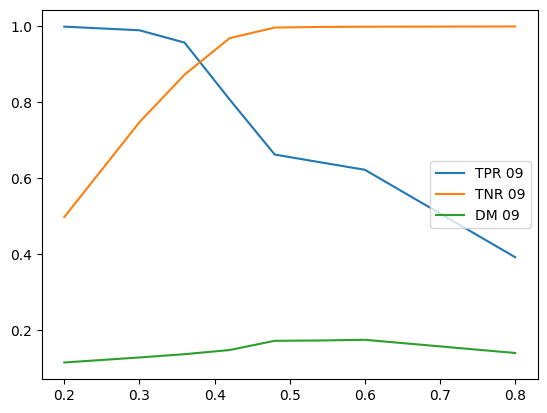

In [34]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()
ax.plot(all_thlds, tprs, label="TPR 09", marker="o")
ax.plot(all_thlds, tnrs, label="TNR 09", marker="o")
ax.plot(all_thlds, dm09, label="DM 09", marker="o")
ax.legend()